# Imports

In [ ]:
from collections import namedtuple

import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns

from src.utils.configure_samplers import stan_nuts, drghmc, drhmc, ghmc
from src.utils.posteriors import get_posterior

%load_ext autoreload
%autoreload 2
sns.set_theme(style="darkgrid")

# Defaults

In [ ]:
HyperParamsTuple = namedtuple(
    "hyper_params",
    [
        "posterior",
        "burn_in",
        "chain_len",
        "global_seed",
        "chain",
        "save_dir",
        "posterior_dir",
        "bridgestan_dir",
    ],
)


SamplerParamsTuple = namedtuple(
    "sampler_params",
    [
        "sampler_type",
        "init_stepsize",
        "reduction_factor",
        "steps",
        "dampening",
        "num_proposals",
        "probabilistic",
    ],
    defaults=[None, None, 2, 1, 0, 1, False],
)

In [ ]:
hp = HyperParamsTuple(
    posterior="funnel10",
    burn_in=0,
    chain_len=1000,
    global_seed=0,
    chain=0,
    save_dir="data/raw",
    posterior_dir="posteriors/",
    bridgestan_dir="../../.bridgestan/bridgestan-2.1.1/",
)

# Reference Draws

In [ ]:
model, ref_draws, posterior_origin = get_posterior(hp.posterior, hp.posterior_dir, "bayeskit")
ref = ref_draws[0]["v"]
fig = px.histogram(ref, nbins=110, histnorm="probability")
fig.show()

# Nuts


In [411]:
model, data, seed, init, inv_metric = stan_nuts(hp)
nuts_fit = model.sample(
    data=data,
    chains=1,
    seed=seed,
    inits=init,
    # metric=inv_metric,
    adapt_init_phase=0  # b/c init from reference draw, already converged to typical set
)
draws = nuts_fit.draws(concat_chains=True)[:, 7:]

19:27:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

19:27:54 - cmdstanpy - INFO - CmdStan done processing.
19:27:54 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 1 had 1 iterations at max treedepth (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [412]:
nuts_fit.metric 

array([[ 4.34877, 16.7192 , 12.8862 , 14.209  , 17.9787 , 26.8174 ,
         8.23846, 12.975  , 16.185  , 15.1993 ]])

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



(-10.0, 10.0)

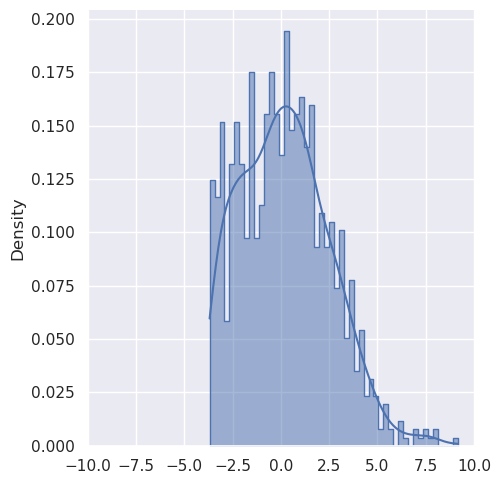

In [416]:
fig = sns.displot(
    kind="hist",
    data=draws[:, 0],
    aspect=1,
    stat="density",
    element="step",
    kde=True,
    bins=50
)

ax = fig.axes[0][0]
ax.set_xlim(-10, 10)

# DR-G-HMC

In [435]:
sp = SamplerParamsTuple(
    sampler_type=drghmc,
    init_stepsize=2,
    reduction_factor=4,
    steps="const_traj_len",
    dampening=0.05,
    num_proposals=3,
    probabilistic=False,
)

sampler = drghmc(hp, sp)
print(sampler._leapfrog_step_sizes, "\n", sampler._leapfrog_step_counts, "\n", sampler._metric)

[0.259812, 0.064953, 0.01623825] 
 [1, 4, 16] 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
draws1 = []
for idx in range(hp.chain_len * 50):
    # print("\n", "*"*40, f" Draw {idx} ", "*"*40)
    draw, logp = sampler.sample()
    draws1.append(draw)
draws1 = np.asanyarray(draws1)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



(-10.0, 10.0)

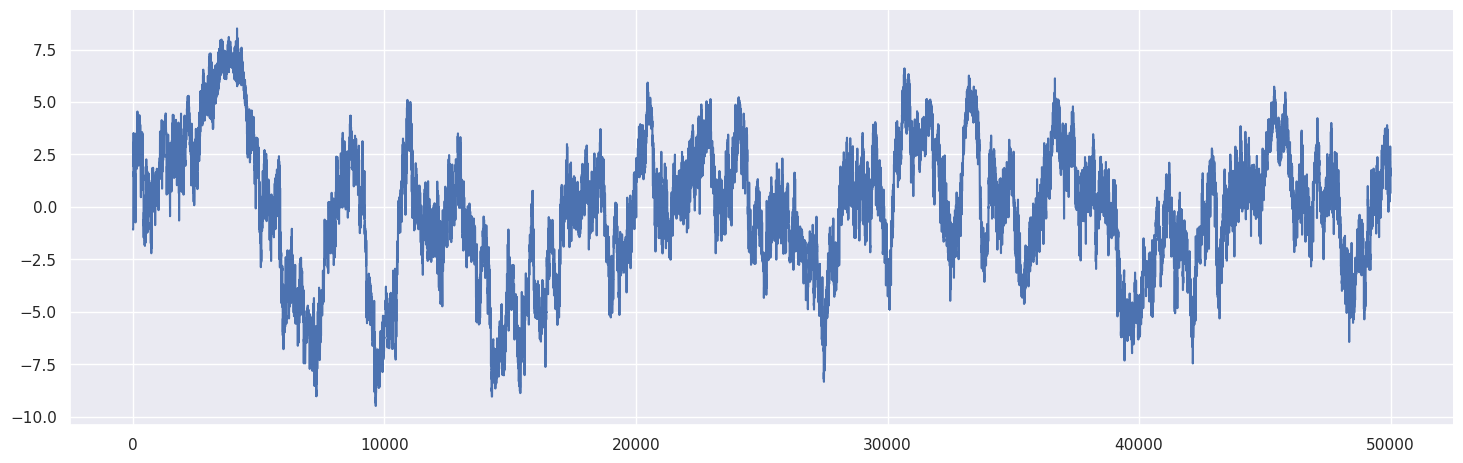

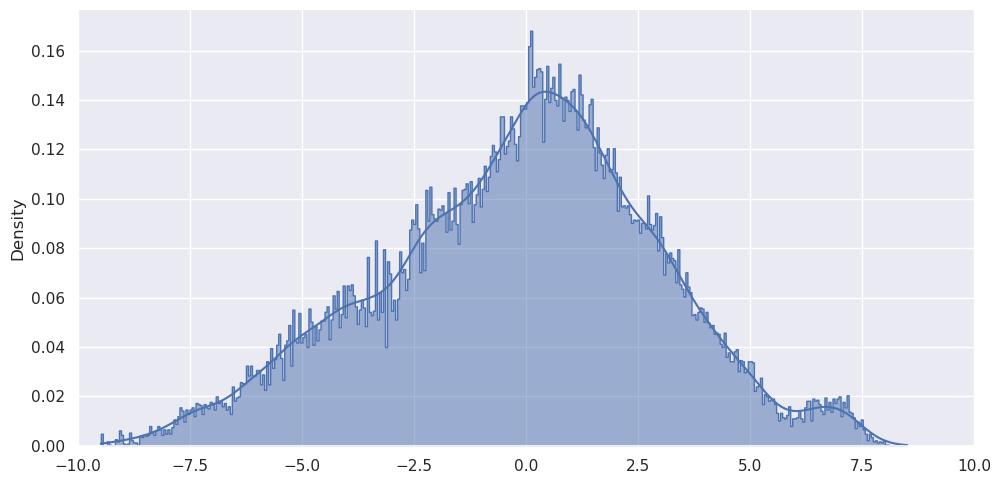

In [437]:
fig = sns.relplot(
    kind="line",
    data=draws1[:, 0],
    aspect=3
)

fig = sns.displot(
    kind="hist",
    data=draws1[:, 0],
    aspect=2,
    stat="density",
    element="step",
    kde=True,
    bins=400
)

ax = fig.axes[0][0]
ax.set_xlim(-10, 10)

# DR-HMC

In [421]:
sp = SamplerParamsTuple(
    sampler_type=drhmc,
    init_stepsize=2,
    reduction_factor=4,
    steps=0.9,
    num_proposals=3,
    probabilistic=False,
)

sampler = drhmc(hp, sp)
print(sampler._leapfrog_step_sizes, sampler._leapfrog_step_counts)
print(sampler._metric)

[0.259812, 0.064953, 0.01623825] [31, 124, 496]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
draws2 = []
for idx in range(hp.chain_len * 10):
    print("\n", "*"*40, f" Draw {idx} ", "*"*40)
    draw, logp = sampler.sample()
    draws2.append(draw)
draws2 = np.asanyarray(draws2)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



(-10.0, 10.0)

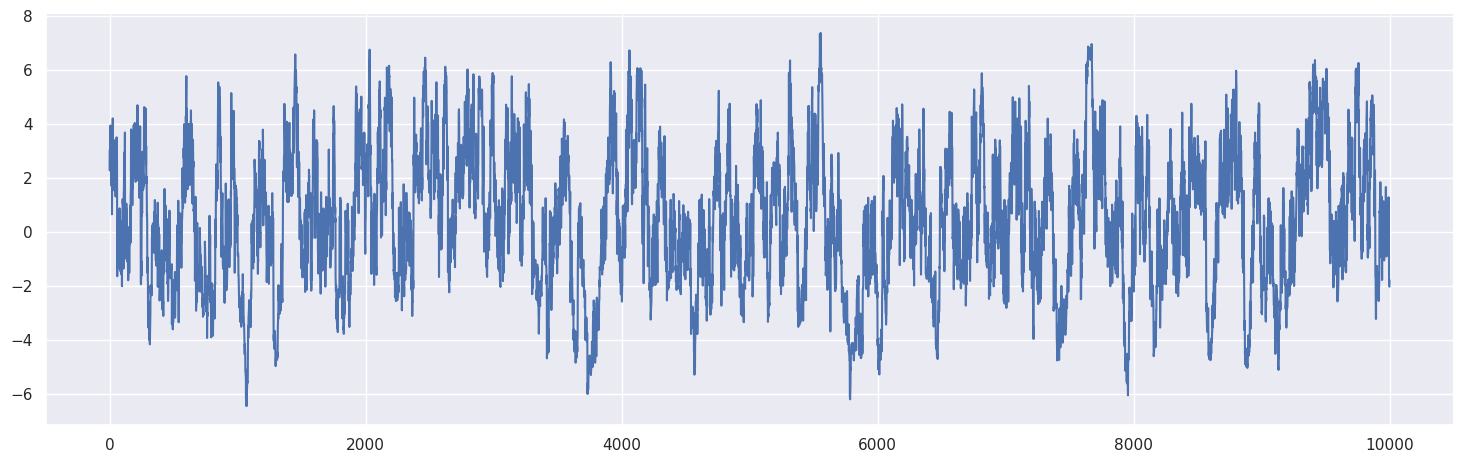

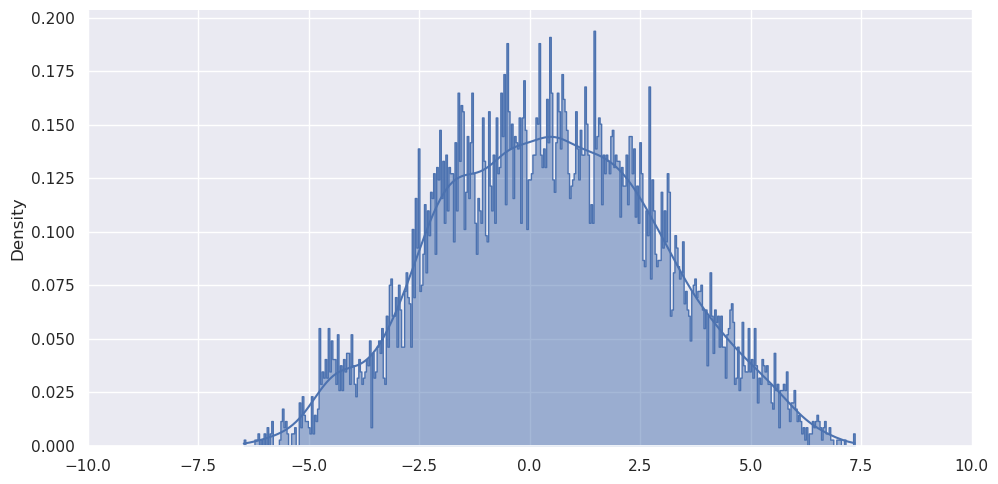

In [427]:
fig = sns.relplot(
    kind="line",
    data=draws2[:, 0],
    aspect=3
)

fig = sns.displot(
    kind="hist",
    data=draws2[:, 0],
    aspect=2,
    stat="density",
    element="step",
    kde=True,
    bins=400
)

ax = fig.axes[0][0]
ax.set_xlim(-10, 10)

# G-HMC

In [398]:
sp = SamplerParamsTuple(
    sampler_type=ghmc,
    init_stepsize=1,
    dampening=0.05,
)

sampler = ghmc(hp, sp)
print(sampler._leapfrog_step_sizes, sampler._leapfrog_step_counts)
print(sampler._metric)

[0.129906] [1]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
draws3 = []
for idx in range(hp.chain_len * 50):
    # print("\n", "*"*40, f" Draw {idx} ", "*"*40)
    draw, logp = sampler.sample()
    draws3.append(draw)
draws3 = np.asanyarray(draws3)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



(-10.0, 10.0)

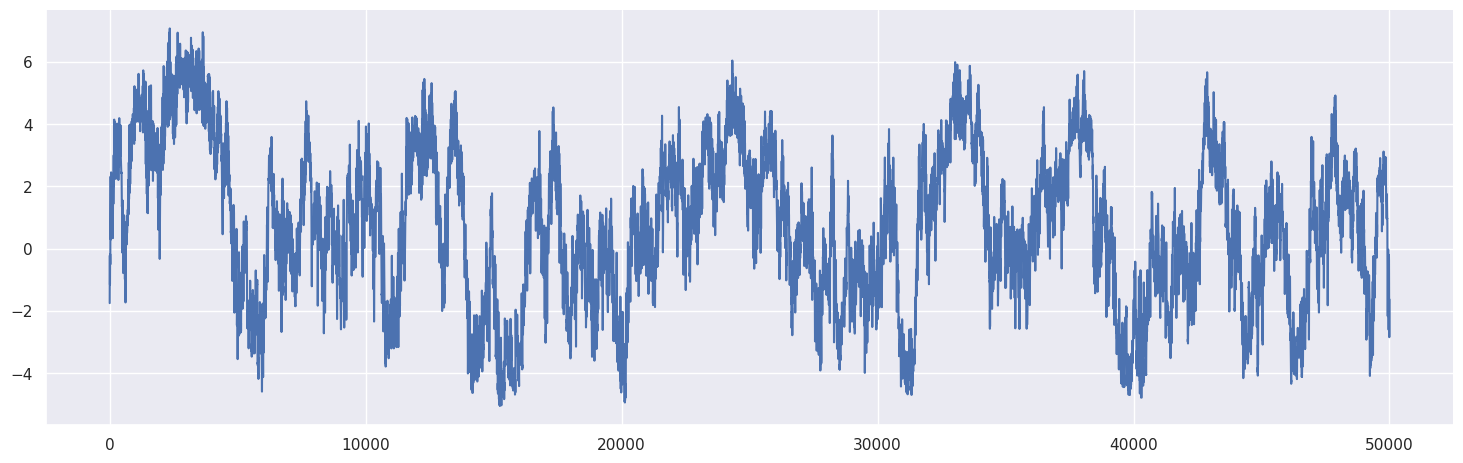

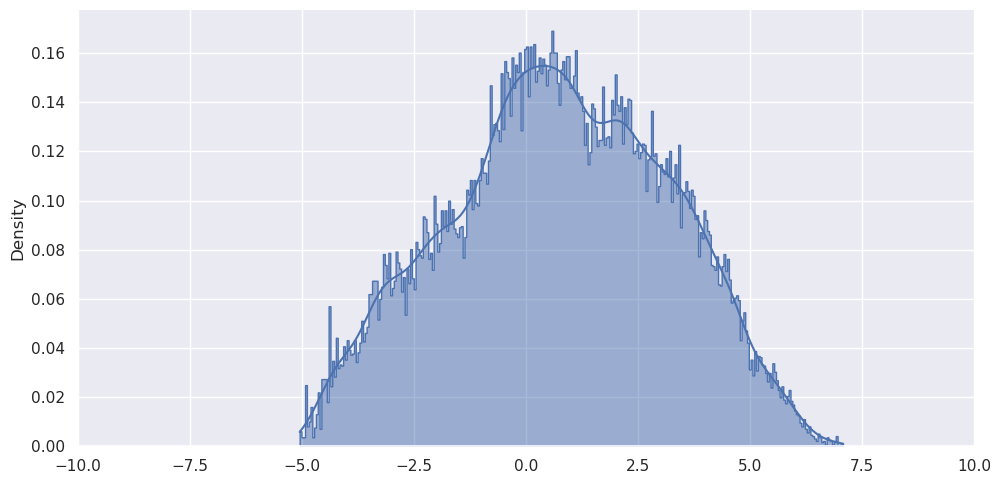

In [426]:
fig = sns.relplot(
    kind="line",
    data=draws3[:, 0],
    aspect=3
)

fig = sns.displot(
    kind="hist",
    data=draws3[:, 0],
    aspect=2,
    stat="density",
    element="step",
    kde=True,
    bins=300,
    
)

ax = fig.axes[0][0]
ax.set_xlim(-10, 10)

# Summary Statistics and Errors

In [446]:
print(np.array(ref).mean(), draws.mean(axis=0)[0], draws1.mean(axis=0)[0], draws2.mean(axis=0)[0], draws3.mean(axis=0)[0])

0.12709468329843085 0.19465666909999996 -0.16120011376354412 0.446850744589875 0.7336800358072695


In [448]:
print(np.square(np.array(ref)).mean(), np.square(draws).mean(axis=0)[0], np.square(draws1).mean(axis=0)[0], np.square(draws2).mean(axis=0)[0], np.square(draws3).mean(axis=0)[0])

9.298068080779494 5.395461602862606 9.778439217820885 6.464320188168846 6.522638462741726
